# DGM Lab 4 - Generative adversarial networks

In this lab session we are going to experiment with generative adversarial networks (GANs). 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Assignment 1

As done many times before (e.g. in lab session 1), load the MNIST dataset using `torchvision` and make sure that the data is normalized between $-1$ and $1$ (i.e. one of the GAN hacks we have covered in the lectures). Also pad the images to make then 32x32 pixels instead of 28x28 pixels. Create a `DataLoader` class that can be used to retrieve batches from the dataset.

In [4]:
data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
data.data = data.data.float().div(255).mul(2).add(-1)
data.data = F.pad(data.data, (2,2,2,2), value=-1)
data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 186776542.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59702165.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67378766.94it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12666574.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Assignment 2
Let's create our generator (G) and discriminator (D) models. Both will be based on a convolutional architecture, and we will largely follow the DCGAN guidelines (see lecture):
1. Use strided convolutions (instead of pooling operations)
2. Use BatchNorm in G and D
3. No fully-connected (dense) layers
4. Use ReLU in G, except for tanh at the output
5. Use LeakyReLU in D

But we have obtained good results by also using LeakyReLU in G as well (the choice is up to you). Here are our additional suggestions:
* Use 5 layers in both G and D. These are regular `Conv2d` layers in D, but `ConvTranspose2d` layers (sometimes also called deconvolution layers) in G. The `Conv2d` layers will reduce the spatial dimensions, while the `ConvTranspose2d` layers will increase them (so you can create larger and larger images by adding more deconvolution layers).
* The input of G will be an $N$-dimensional noise vector $\mathbf{z}$, which you treat as a 1x1 "image" with $N$ channels. Ideally, you then increase your image dimensions in an exponential fashion: 1x1 $\rightarrow$ 2x2 $\rightarrow$ 4x4 $\rightarrow$ 8x8 $\rightarrow$ 16x16 $\rightarrow$ 32x32 (so indeed: 5 layers in total). Reduce the number of channels in each layer in an exponential fashion as well. Consult the documentation on how you can achieve all this by playing with the kernel size, padding, stride and dilation (hint: dilation can be always be set to 1).
* The same goes for D, but here you reduce the spatial dimensions exponentially.
* Don't include any bias parameters in the convolutional layers.
* Keep the number of feature maps in G and D high enough to allow for reasonable expressiveness.
* Use a noise vector size $N$ of about 50

Check your models (and especially the output dimensions of G and D) by feeding in a random noise vector.

In [5]:
# nz = noise vector size
# ngf = number of generator filters
class DC_Generator(nn.Module):
    def __init__(self, nz = 50, ngf=64):
        super(DC_Generator, self).__init__()
        self.main = nn.Sequential(
            #I -> 1x1 layer
            #2x2, 512 filters
            nn.ConvTranspose2d(nz,ngf*8 ,kernel_size=4 ,stride=2, padding=1, bias=False, dilation=1),   #ks, stride, padding increase spatial dim by 2
            nn.BatchNorm2d(ngf*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            #4x4, 256 filters
            nn.ConvTranspose2d(ngf*8,ngf*4 ,kernel_size=4 ,stride=2 ,padding=1 , bias=False, dilation=1),       
            nn.BatchNorm2d(ngf*4),
            nn.LeakyReLU(),
            
            #8x8, 128 filters
            nn.ConvTranspose2d(ngf*4,ngf*2 ,kernel_size=4 ,stride=2 ,padding=1 , bias=False, dilation=1),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(),
            
            #16x16, 64 filters
            nn.ConvTranspose2d(ngf*2,ngf ,kernel_size=4 ,stride=2 ,padding=1 , bias=False, dilation=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(),
            
            #32x32, 3 filters
            nn.ConvTranspose2d(ngf, 1 ,kernel_size=4 ,stride=2 ,padding=1 , bias=False, dilation=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.main(z)

In [6]:
# nf = number of discriminator filters
class DC_Discriminator(nn.Module):
    def __init__(self, nf=64):
        super(DC_Discriminator, self).__init__()
        self.main = nn.Sequential(
            #I -> 32x32 iamges 
            #16x16, 64 filters
            nn.Conv2d(1, nf, kernel_size=4, stride=2, padding=1, bias=False, dilation=1),
            nn.LeakyReLU(0.2, inplace=True),

            #8x8, 128 filters
            nn.Conv2d(nf, nf*2, kernel_size=4, stride=2, padding=1, bias=False, dilation=1),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),

            #4x4, 256 filters
            nn.Conv2d(nf*2, nf*4, kernel_size=4, stride=2, padding=1, bias=False, dilation=1),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),

            #2x2, 512 filters
            nn.Conv2d(nf*4, nf*8, kernel_size=4, stride=2, padding=1, bias=False, dilation=1),
            nn.BatchNorm2d(nf*8),
            nn.LeakyReLU(0.2, inplace=True),

            #1x1, 1 filter
            nn.Conv2d(nf*8, 1, kernel_size=4, stride=2, padding=1, bias=False, dilation=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [7]:
z = torch.randn(1, 50, 1, 1)
gen = DC_Generator()
disc = DC_Discriminator()

print(z.shape)
output = gen(z)
print(output.shape)
output = disc(output)
print(output.shape)

torch.Size([1, 50, 1, 1])
torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 1, 1])


## Assignment 3
It is time to train our first GAN to mimic MNIST images. As in all lab sessions, we will write a train loop over a number of epochs. In each epoch we will construct and process minibatches that consist of either 100% real MNIST images or 100% fake images generated by G (as is suggested in one of the GAN hacks). A couple of important details you should consider:

* Since we train two models, you will need two optimizers. Use a very small learning rate (ca. 0.0001).
* We will use the non-saturating GAN objective to train G. This means that for D we maximize $\log(D(x)) + \log(1 - D(G(z)))$, and for G we maximize $\log(D(G(z)))$ (expectations are omitted).
* The GAN objectives for D and G look very much like the binary cross-entropy loss function, which is implemented by the `BCELoss` class:
$$\text{BCELoss} = -\left[y_n\cdot \log(x_n) + (1 - y_n)\cdot \log(1 - x_n)\right]$$
In this formula, $y_n$ is the target label ($0$ or $1$) and $x_n$ is the network's output (between $0$ and $1$). If you use $1$ as real target label and $0$ as fake target label to train D, and $1$ as target label to train G, you can make clever use of just a single instantiation of the `BCELoss` class.
* A possible training iteration could go as follows:
  1. Get a batch from the MNIST dataset, feed the batch through D, calculate the loss, calculate D's parameter gradients.
  2. Sample a batch $B$ of fake images through G, feed the batch through D, calculate the loss, calculate (and accumulate) D's parameter gradients.
  3. Do one optimization step for D.
  4. Use the same batch $B$, feed it through D, calculate the loss for G, calculate G's parameter gradients.
  5. Do one optimization step for G.
* Make sure to run everything on the GPU.
* Remember what we learned about momentum in the network's optimizer!
* Tip: you can mount your Google Drive to Google Colab. This allows you to persist your model parameters even after disconnection with Colab. We highly recommend that you look into this (we will compare different models in assignment 6).
* Tip (without obligation): create a batch of fixed random vectors that you can use to sample images from G every $x$ training iterations. You can arrange these images in a grid using the `make_grid` function from `torchvision.utils` and save this grid in a list. You can then submit this grid of images to Tensorboard, where you can easily inspect them. You can alternatively create an animation/interactive HTML widget that allows you to walk through the images and get visual feedback about the quality of the images that are generated. For example:
```
import matplotlib.pyplot as plot
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in image_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())
```

In [8]:
gen = DC_Generator().to(device)
disc = DC_Discriminator().to(device)

In [9]:
#Loss function and optimizer
criterion = nn.BCELoss()

fixed_noise = torch.randn(128, 50, 1, 1, device=device)

optimizerD = optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
#Training loop
epochs = 10
img_list = []
iters = 0
gen_loss = []
disc_loss = []

for epoch in range(epochs):
    for i,(images,_) in enumerate(data_loader):
        #-----------------------DISCRIMINATOR-----------
        disc.train()
        
        #Batch of real data
        #print(images.shape[0])
        images = images.to(device)
        
        #Feed through discriminator
        output = disc(images).squeeze(2).squeeze(2)
        #print(output.cpu().shape)

        #Calculate loss of real data
        #print(torch.ones_like(output).shape)
        error_real = criterion(output, torch.ones(images.shape[0],1, device=device))

        #Discriminator parameter gradients
        error_real.backward()

        #Generate noise of size=batch size
        noise = torch.randn(images.shape[0], 50, 1, 1, device=device)

        #Feed through generator
        fake = gen(noise)
        #print(fake.cpu().shape)

        #Feed through discriminator
        output = disc(fake.detach()).squeeze(2).squeeze(2)
        #print(output.cpu().shape)
        
        #Calculate loss of fake data
        #print(torch.zeros_like(output).shape)
        error_fake = criterion(output, torch.zeros(images.shape[0],1, device=device))

        #Discriminator parameter gradients
        error_fake.backward()

        #Accumulate discriminator parameter gradients
        error_disc = error_real + error_fake

        #Update discriminator parameters
        optimizerD.step()

        #-----------------------GENERATOR-----------------------#
        gen.train()
        #Feed noise through discriminator
        output = disc(fake).squeeze(2).squeeze(2)

        #Calculate loss of generator
        #torch.ones_like(output)
        error_gen = criterion(output, torch.ones(images.shape[0],1, device=device))

        #Generator parameter gradients
        error_gen.backward()

        #Update generator parameters
        optimizerG.step()
        
        if (i+1) % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'% (epoch, epochs, i, len(data_loader),error_disc.item(), error_gen.item()))
           
        # Save losses
        gen_loss.append(error_gen.item())
        disc_loss.append(error_disc.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                gen.eval()
                fake_test = gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_test, padding=2, normalize=True))
        
        iters+=1

[0/10][99/469]	Loss_D: 1.3972	Loss_G: 0.2380
[0/10][199/469]	Loss_D: 2.8108	Loss_G: 0.0641
[0/10][299/469]	Loss_D: 2.6616	Loss_G: 0.0782
[0/10][399/469]	Loss_D: 3.0055	Loss_G: 0.0513
[1/10][99/469]	Loss_D: 0.0874	Loss_G: 2.5647


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_loss,label="G")
plt.plot(disc_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print(img_list[0].shape)

In [ ]:
import matplotlib.pyplot as plot
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

## Assignment 4
Now that you have trained your first GAN, you have probably already looked at the generated images. They should look near-realistic if everything went well. But visual inspection is highly subjective, not scalable and difficult to reproduce, as we have covered in the lectures. In this assignment we will therefore implement a quantitative evaluation metric: the Fréchet Inception Distance (FID).

To calculate the FID, you need a pretrained network that acts as a feature extractor. In theory you can take any network you want, but it makes sense in this context to use a network that was trained on MNIST as well. We provide you with an external Python-file `mnist_extractor.py` that contains both a model definition and a method to download pretrained weights for this model. You can instantiate the pretrained model using the `mnist()` function. In the `extract()` method we have stripped the final output layer from the model, such that the feature vector of the prefinal layer is returned. Make sure to put the model in evaluation mode when extracting the features &ndash; this will disable the stochastic dropout layers.
NB: if you want, you can also use the MNIST classifier that you trained in the first lab session.

The FID requires that you fit two multivariate Gaussian distributions to the extracted feature vectors. For this, you can use the regular sample mean en sample covariance. Make good use of NumPy and SciPy to calculate these quantities, and use it as well to calculate vector norms, matrix square roots, traces...

Is your obtained FID a reasonable number? That's hard to say. FID is highly model-, dataset- and dataset-size-specific, so it can only be used to compare models to each other. Assessing the performance of a single, isolated model based on FID is difficult. As an exercise, try to increase e.g. the size of the test dataset and see how it affects the FID.

## Assignment 5
In this next assignment we will implement a Wasserstein GAN (WGAN). You can recycle most of the code you have written until now. The generator and discriminator (called 'critic' in WGAN lingo) can be almost exact copies: the only detail that is different is that the critic is *not* a classifier, but should output continuous, unbounded values (both positive and negative).

To train your WGAN, we will follow closely the algorithm as sketched in the original paper (Arjovsky et al., 2017):

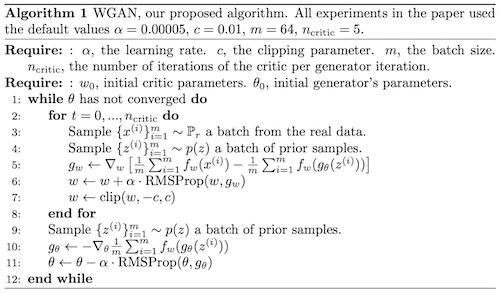

Some important details to which we want to draw your attention:
* The optimizer is RMSprop instead of Adam.
* The learning rate is really small!
* The critic is trained $n_{\text{critic}}$ times more than the generator.
* To train the critic, you need to perform gradient *ascent*; to train the generator, you perform gradient *descent* (which is the default).
* Take a look at the `clamp_` function in PyTorch to clip the weights of the critic.

You should see both the generator's loss and the Wasserstein estimate (i.e. the negative critic loss) going down during training. Due to the small learning rate, you will probably need more epochs compared to assigment 3.

## Assignment 6
Compare the performance of the regular GAN (assignment 3) with that of the Wasserstein GAN (assignment 5) in terms of Fréchet Inception Distance (FID). What are your conclusions?